In [1]:
#### https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing#scrollTo=wf31gQavdtfG
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import json
import re
import regex
import tensorflow as tf
import time
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import chain
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /Users/luki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/luki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Set up GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
data = pd.read_json('../data/APP_ALL.json')
df = pd.DataFrame(data)
df

,doc_id,text,title,year,author,typ,zeitschrift,heftnummer,band,url,textnummer,sprache,institution
0,Band 1 (1903-1904).1.pdf,"Jur ArmenHausversorgung. Von C. Marty, Pfarrer...",Zur Armenhausversorgung,1903,"Marty, E.",Article,Der Armenpfleger,1,1,http://doi.org/10.5169/seals-837880,1,german,SAPK
1,Band 1 (1903-1904).10.pdf,"Literatur. Wentona Woser, die weibliche Jugend...",Literatur,1903,NaN,BookReview,Der Armenpfleger,3,1,NaN,2,german,SAPK
2,Band 1 (1903-1904).11.pdf,— 24 — Mat- und Attsknttftertcilttng (unentgel...,Rat- und Auskunftserteilung,1903,NaN,Group,Der Armenpfleger,3,1,NaN,3,german,SAPK
3,Band 1 (1903-1904).12.pdf,Der Armenpfleger. Monatsschrift für Armenpfleg...,Die freiwillige und Einwohnerarmenpflege der S...,1903,[s.n.],Article,Der Armenpfleger,4,1,http://doi.org/10.5169/seals-837884,4,german,SAPK
4,Band 1 (1903-1904).13.pdf,Aie behördliche Meöertragung amtlicher Armenpf...,Die behördliche Uebertragung amtlicher Armenpf...,1903,[s.n.],Article,Der Armenpfleger,4,1,http://doi.org/10.5169/seals-837885,5,german,SAPK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7164,Band 99 (2002).96.pdf,Praxishilfe/Veranstaltungen ZeSo 10/2002 meind...,Veranstaltungen,2002,NaN,Group,Zeitschrift für Sozialhilfe,10,99,NaN,7847,german,SAPK
7165,Band 99 (2002).97.pdf,ZeSo 11/2002 Schwerpunkt Grünes Licht für das ...,Grünes Licht für das Beitrittsverfahren der Ka...,2002,"Zürcher, Ernst",Article,Zeitschrift für Sozialhilfe,11,99,http://doi.org/10.5169/seals-840364,7848,german,SAPK
7166,Band 99 (2002).98.pdf,Die IVSE und der Neue Finanzausgleich Der Neue...,Die IVSE und der Neue Finanzausgleich,2002,"Zürcher, Ernst",Article,Zeitschrift für Sozialhilfe,11,99,http://doi.org/10.5169/seals-840365,7849,german,SAPK
7167,Band 99 (2002).99.pdf,IVSE: Fortschritte für die Suchttherapieinrich...,IVSE : Fortschritte für die Suchttherapieeinri...,2002,"Simmel, Ueli",Article,Zeitschrift für Sozialhilfe,11,99,http://doi.org/10.5169/seals-840366,7850,german,SAPK


In [5]:
unique_types = df['typ'].unique()
print(unique_types)

['Article' 'BookReview' 'Group' 'Preface']


In [42]:
### Eventuell einschränken!!
df = df[df['typ'].isin(['Article', 'BookReview']) & df['year'].between(1919, 1990)]

In [43]:
print("Min",df['year'].min())
print("Max", df['year'].max())

Min 1919
Max 1990


In [44]:
len(df)

2663

In [45]:
print("Min",df['year'].min())
print("Max", df['year'].max())

Min 1919
Max 1990


In [46]:
## 1 Nummern und Klammern rauslöschen... 
def remove_numbers(s):
    return re.sub(r'\d+', '', s)
df.loc[:, 'text_cl'] = df['text'].apply(remove_numbers)

### 2 Klammern rauslöschen...
df['text_cl'] = df['text_cl'].str.replace(r'\(|\)', '', regex=True)
df['text_cl'] = df['text_cl'].str.replace('"', '')

In [47]:
def get_exclusive_punctuation_words(texts):
    end_punctuations = re.compile(r"[\.\!\?]['\"]?$")
    
    # Convert all words to lowercase once
    all_words_lower = ' '.join(texts).lower().split()
    all_words_set = set(all_words_lower)
    word_freq = Counter(all_words_lower)

    # Get words with end punctuation
    words_with_end_punctuation = [word for word in all_words_lower if end_punctuations.search(word)]
    
    # Strip punctuation from the end of these words
    words_stripped = [re.sub(end_punctuations, '', word) for word in words_with_end_punctuation]
    
    # Adjust here: check if the word frequency is greater than 5
    exclusive_punctuation_words = set(word for word, stripped_word in zip(words_with_end_punctuation, words_stripped) 
                                     if stripped_word not in all_words_set and word_freq[word] > 5)
    
    # Sort by frequency in descending order while ensuring each word appears only once
    sorted_exclusives = sorted(exclusive_punctuation_words, key=lambda x: word_freq[x], reverse=True)
    
    return sorted_exclusives

exclusives = get_exclusive_punctuation_words(df['text_cl'])
print("Exclusive words with punctuation:", exclusives)

Exclusive words with punctuation: ['.', 'bzw.', 'vgl.', 'eidg.', 'd.h.', 'pfr.', 'u.a.', 'bezw.', 'resp.', 'frl.', 'geb.', 'inkl.', 'bd.', 'phil.', 'z.g.b.', 'j.-rh.', 'kt.', 'vergl.', 'allg.', 'etc.', 'b.v.', 'evtl.', 'mill.', 'tab.', 'a.g.', 'brn.', 'kts.', 'armenpfleger-ronferenz.', 'xv.', 'a.pfr.', 'et».', 'ärt.', 'e.g.', 'ffr.', 'mk.', 'usf.', 'städt.', '?', 'theol.', 'apfl.', 'aarg.', 'vr.', 'bahnhofstr.', 'xiii.', 'appenz.', 'z.t.', 'mitg.', 'iîr.', 'hrn.', 'kart.', 'dipl.', 'dez.', 'sept.', 'u.a.m.', 'tél.', 'seefeldstr.', 'oec.', '!', 'chr.', 'v.b.', 'std.', 'a.d.', 'selnaustr.', 'sch.k.g.', '«...', 'jahrg.', 'ausmachte.', 'publ.', 'a.a.o.', 'sfr.', 'insbes.', 'm.-e.', 'xix.', 'ausreiche.', 'vol.', 'dgl.', 'jg.', 'cie.', 'i.sa.', 'f.d.', 'diss.', 'xxxiii.', 'öffentl.', 'gebr.', 'abf.', 'wiedergewählt.', 'stat.', 'a.z.', 'mahle.', 'r.b.', 'rud.', 'zurückzuvergüten.', 'pag.', 'gesch.', 'exp.', 'soz.', 'freiw.', 'herauskommt.', 'cit.', 'nov.', 'joh.', 'xiv.', 'a.o.', 'töß-wintert

In [48]:
exclusives = [element for element in exclusives if element not in ['.', '?', '!', ".'"]]
len(exclusives)

172

In [49]:
exclusives = [word.rstrip('.') for word in exclusives]
print(exclusives)

['bzw', 'vgl', 'eidg', 'd.h', 'pfr', 'u.a', 'bezw', 'resp', 'frl', 'geb', 'inkl', 'bd', 'phil', 'z.g.b', 'j.-rh', 'kt', 'vergl', 'allg', 'etc', 'b.v', 'evtl', 'mill', 'tab', 'a.g', 'brn', 'kts', 'armenpfleger-ronferenz', 'xv', 'a.pfr', 'et»', 'ärt', 'e.g', 'ffr', 'mk', 'usf', 'städt', 'theol', 'apfl', 'aarg', 'vr', 'bahnhofstr', 'xiii', 'appenz', 'z.t', 'mitg', 'iîr', 'hrn', 'kart', 'dipl', 'dez', 'sept', 'u.a.m', 'tél', 'seefeldstr', 'oec', 'chr', 'v.b', 'std', 'a.d', 'selnaustr', 'sch.k.g', '«', 'jahrg', 'ausmachte', 'publ', 'a.a.o', 'sfr', 'insbes', 'm.-e', 'xix', 'ausreiche', 'vol', 'dgl', 'jg', 'cie', 'i.sa', 'f.d', 'diss', 'xxxiii', 'öffentl', 'gebr', 'abf', 'wiedergewählt', 'stat', 'a.z', 'mahle', 'r.b', 'rud', 'zurückzuvergüten', 'pag', 'gesch', 'exp', 'soz', 'freiw', 'herauskommt', 'cit', 'nov', 'joh', 'xiv', 'a.o', 'töß-winterthur', 'klageberechtigt', 'min', 'b.-h', 'a.u.ng', 'u.u', 'i.s', 'stockerstr', 'j.-h', 'dergl', 'zl', 'ausdrückt', 'abzuwälzen', 'xxxvi', 'nrn', 'j.p', 

In [50]:
# Open file for writing
with open("exceptions_sentenizer.txt", "w", encoding="utf-8") as f:
    for item in exclusives:
        f.write("%s\n" % item)

In [51]:
sentence_tokenizer = nltk.data.load("tokenizers/punkt/german.pickle")
sentence_tokenizer._params.abbrev_types.update(exclusives)

## Neue Funktion, welche Ausnahmen berücksichtigt. 
def tokenize_text(text):
    # Update the sentence tokenizer with the modified abbreviation list
    sentence_tokenizer._params.abbrev_types.update(exclusives)
    
    # Tokenize the text using the modified sentence tokenizer
    split_sentences = sentence_tokenizer.tokenize(text)
    
    return split_sentences

In [52]:
### Schauen, ob das update funktioniert hat: 
data_test  = {
    'typ': ['Article', 'BookReview', 'Article', 'BookReview'],
    'year': [1945, 1980, 1975, 1985],
    'text': [
        'Die Studie wurde von Dr. phil. Müller durchgeführt. Sie wurde in Zürich, kt. Zürich veröffentlicht. Der eidg. Rat hat neue Regelungen beschlossen, inkl. neue Steuergesetze. Vergleiche vgl. Tabelle 1 u.a. Ergebnisse. Die Resultate sind in tab. 2 gezeigt.',
        'Vergleiche vgl. Tabelle 1 u.a. Ergebnisse. Die Resultate sind in tab. 2 gezeigt. Die Studie wurde von Dr. phil. Müller durchgeführt. Sie wurde in Zürich, kt. Zürich veröffentlicht. Der eidg. Rat hat neue Regelungen beschlossen, inkl. neue Steuergesetze.',
        'Der eidg. Rat hat neue Regelungen beschlossen, inkl. neue Steuergesetze. Die Untersuchung, d.h. die Analyse, zeigt interessante Trends, resp. Abweichungen. Der pfr. Müller war ebenfalls anwesend. Sie wurde in Zürich, kt. Zürich veröffentlicht. Vergleiche vgl. Tabelle 1 u.a. Ergebnisse.',
        'Die Untersuchung, d.h. die Analyse, zeigt interessante Trends, resp. Abweichungen. Vergleiche vgl. Tabelle 1 u.a. Ergebnisse. Die Studie wurde von Dr. phil. Müller durchgeführt. Der pfr. Müller war ebenfalls anwesend. Sie wurde in Zürich, kt. Zürich veröffentlicht.'
    ]
}

dtest = pd.DataFrame(data_test)

# Apply the tokenizing function to the 'text' column
dtest['tokenized_text'] = dtest['text'].apply(tokenize_text)

In [53]:
print(dtest['tokenized_text'][1])

['Vergleiche vgl. Tabelle 1 u.a. Ergebnisse.', 'Die Resultate sind in tab. 2 gezeigt.', 'Die Studie wurde von Dr. phil. Müller durchgeführt.', 'Sie wurde in Zürich, kt. Zürich veröffentlicht.', 'Der eidg. Rat hat neue Regelungen beschlossen, inkl. neue Steuergesetze.']


In [54]:
df['sentences'] = df['text_cl'].apply(tokenize_text)

In [55]:
def tokenize_sentences_into_words(sentence_list):
    tokenized_sentences = [word_tokenize(sentence, language='german') for sentence in sentence_list]
    return tokenized_sentences

df['tokenized_sentences'] = df['sentences'].apply(tokenize_sentences_into_words)
df['tokenized_sentences'].iloc[10]

[['Ursachen',
  'des',
  'Kauxerismus',
  'in',
  'Vergangenheit',
  'unö',
  'Gegenwart',
  '.'],
 ['In',
  'Der',
  'Untersuchung',
  'über',
  'die',
  'Armeiwcrhältnisse',
  'einer',
  'bernischen',
  'standgemeinde',
  't',
  '»',
  'i',
  'Gebiete',
  'des',
  'Hügellandes',
  'und',
  'der',
  'Voralpen',
  'führte',
  'der',
  'Berichterstatter',
  'im',
  'Jahre',
  'folgende',
  'Gründe',
  'der',
  'dortigen',
  'Armenlast',
  'an',
  ':',
  '.'],
 ['Ueber',
  '«',
  'völkernng',
  'in',
  'einem',
  'Teil',
  'der',
  'Gemeinde',
  ':',
  '.'],
 ['Hypothekarschuldenlast', ';', '.'],
 ['die',
  'Hungerjahre',
  ',',
  'welche',
  'das',
  'verstenerbare',
  'Vermögen',
  'in',
  'der',
  'betreffenden',
  'Gemeinde',
  'in',
  'den',
  'Jahren',
  '-',
  'um',
  ',',
  'Franken',
  'verminderten',
  ':',
  '.'],
 ['das',
  'Verdrängen',
  'des',
  'Seidenwindens',
  'im',
  'Hanse',
  'durch',
  'die',
  'Maschinenindnstrie',
  'und',
  'das',
  'durch',
  'die',
  'Tuchmärk

In [56]:
def remove_punctuation(tokens):
    # Pattern to match any punctuation character in any language
    # \p{P} matches any kind of punctuation character
    # \p{M} might be necessary to keep combining characters like accents => EVENTUELL einbauen...
    pattern = regex.compile(r"\p{P}")

    # For each token, remove punctuation characters
    # and keep tokens that still contain some content after cleanup
    return [pattern.sub('', token) for token in tokens if pattern.sub('', token)]

def process_nested_list(nested_list):
    return [remove_punctuation(sentence) for sentence in nested_list]

# Apply the function on each nested list in 'tokenized_sentences'
df['cleaned_sentences'] = df['tokenized_sentences'].apply(process_nested_list)
df['cleaned_sentences'].iloc[10]

[['Ursachen', 'des', 'Kauxerismus', 'in', 'Vergangenheit', 'unö', 'Gegenwart'],
 ['In',
  'Der',
  'Untersuchung',
  'über',
  'die',
  'Armeiwcrhältnisse',
  'einer',
  'bernischen',
  'standgemeinde',
  't',
  'i',
  'Gebiete',
  'des',
  'Hügellandes',
  'und',
  'der',
  'Voralpen',
  'führte',
  'der',
  'Berichterstatter',
  'im',
  'Jahre',
  'folgende',
  'Gründe',
  'der',
  'dortigen',
  'Armenlast',
  'an'],
 ['Ueber', 'völkernng', 'in', 'einem', 'Teil', 'der', 'Gemeinde'],
 ['Hypothekarschuldenlast'],
 ['die',
  'Hungerjahre',
  'welche',
  'das',
  'verstenerbare',
  'Vermögen',
  'in',
  'der',
  'betreffenden',
  'Gemeinde',
  'in',
  'den',
  'Jahren',
  'um',
  'Franken',
  'verminderten'],
 ['das',
  'Verdrängen',
  'des',
  'Seidenwindens',
  'im',
  'Hanse',
  'durch',
  'die',
  'Maschinenindnstrie',
  'und',
  'das',
  'durch',
  'die',
  'Tuchmärkte',
  'der',
  'nächsten',
  'größer',
  'Stadt',
  'veranlasste',
  'Nachlassen',
  'von',
  'Ban',
  'und',
  'Vera

In [57]:
## 2 OCR-Qualität messen und schlechte Dokumente ausschliessen. 
### Using GNU ANSPELL Lists of German words and Helvetism (special Swiss words) from here: https://sourceforge.net/projects/germandict/files/
### I came across the word list here: https://github.com/adbar/German-NLP

german_word_list = []

with open('GNUAnspell_helvetismen.txt', 'r', encoding='ISO-8859-1') as fp: 
    for line in fp: 
            x = line[:-1]

            # add items to the list
            german_word_list.append(x)

with open('GNUAnspell_german.dic', 'r', encoding='ISO-8859-1') as fp: 
    for line in fp: 
            x = line[:-1]

            # add items to the list
            german_word_list.append(x)

# Take a look at the list
LCgerman_word_list = [word.lower() for word in german_word_list]
print(len(LCgerman_word_list))       

2155513


In [58]:
### Die tokenisierten Sätze zu Lowercase machen. 
# Function to convert tokens in a sentence to lowercase
def lowercase_tokens(sentence):
    return [token.lower() for token in sentence]

# Function to apply the lowercase conversion on nested lists
def process_nested_list_for_lower(nested_list):
    return [lowercase_tokens(sentence) for sentence in nested_list]

# Apply the function on each nested list in 'cleaned_sentences'
df['cleaned_sentences_LC'] = df['cleaned_sentences'].apply(process_nested_list_for_lower)

In [59]:
# Convert german_word_list_LC to a set for faster look-up
LCgerman_word_list = set(LCgerman_word_list)

def calculate_percentage(tokens, LCgerman_word_list):
    # Calculate the percentage of tokens in the word list
    matching_tokens = [token for token in tokens if token in LCgerman_word_list]
    percentage = (len(matching_tokens) / len(tokens)) * 100 if tokens else 0
    return percentage

# Flatten the nested lists and calculate the percentage
df['ocr_quality'] = df['cleaned_sentences_LC'].apply(lambda nested_list: calculate_percentage(list(chain.from_iterable(nested_list)), LCgerman_word_list))

# Check and print if any entries have OCR quality below 90
if (df['ocr_quality'] < 90).any():
    print(df[df['ocr_quality'] < 90])
else:
    print("No entries with OCR quality below 90.")

                          doc_id  \
315   Band 17 (1919-1920).10.pdf   
318   Band 17 (1919-1920).13.pdf   
319   Band 17 (1919-1920).14.pdf   
324   Band 17 (1919-1920).19.pdf   
325    Band 17 (1919-1920).2.pdf   
...                          ...   
4646       Band 87 (1990).10.pdf   
4649       Band 87 (1990).14.pdf   
4658       Band 87 (1990).25.pdf   
4666       Band 87 (1990).34.pdf   
4691       Band 87 (1990).62.pdf   

                                                   text  \
315   Der Armenpfleger. Monatsschrift für Armenpsteg...   
318   Der Armenpfleger. Monatsschrift für Armenpfleg...   
319   Rückbürgerung ehemaliger Schweizerinnen. (Ents...   
324   Der Armenpfleger. Monatsschrift für Armenpfleg...   
325   Der Armenpfleger. Monatsschrift für Armenpfleg...   
...                                                 ...   
4646  Die «ZöF» vor mehr als 100 Jahren Zur Zeit ver...   
4649  Neue Mitglieder der SKöF Der Vorstand hat in s...   
4658  nicht zuletzt auch einen Gener

In [61]:
df_clean = df[df['ocr_quality'] >= 85]

# Now df_high_quality contains only the entries where OCR quality is 90% or higher
print(f"Number of entries with high OCR quality: {len(df_clean)}")

Number of entries with high OCR quality: 2519


In [62]:
badqual = df[df['ocr_quality'] < 85]

In [63]:
type(badqual)

pandas.core.frame.DataFrame

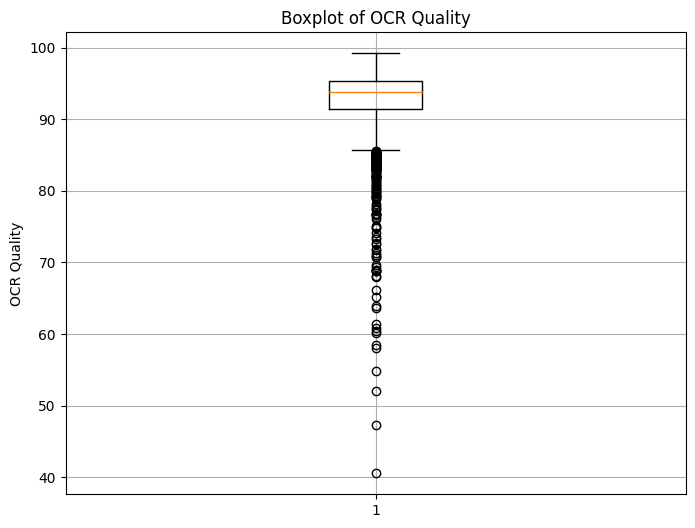

In [64]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['ocr_quality'])
plt.title('Boxplot of OCR Quality')
plt.ylabel('OCR Quality')
plt.grid(True)
plt.show()

In [65]:
mean_ocrquality = df['ocr_quality'].mean()
print("Mean of OCR Quality:", mean_ocrquality)

Mean of OCR Quality: 92.57293087777018


In [66]:
median_ocrquality = df['ocr_quality'].median()
print("Median of OCR Quality:", median_ocrquality)

Median of OCR Quality: 93.7636761487965


In [67]:
badqual['text']

318     Der Armenpfleger. Monatsschrift für Armenpfleg...
325     Der Armenpfleger. Monatsschrift für Armenpfleg...
332     Der Armenpfleger. Monatsschrift für Armenpfleg...
335     VerwandtenunterMtzung. (Entscheide des Departe...
342     Literatur. Statistische Mitteilungen betreffen...
                              ...                        
4613    Neue Mitglieder der SKöF Anlässlich der letzte...
4622    Arbeitsschwerpunkte der SKöF für die Jahre 199...
4646    Die «ZöF» vor mehr als 100 Jahren Zur Zeit ver...
4649    Neue Mitglieder der SKöF Der Vorstand hat in s...
4666    Programm des Weiterbildungskurses der SKöF vom...
Name: text, Length: 144, dtype: object

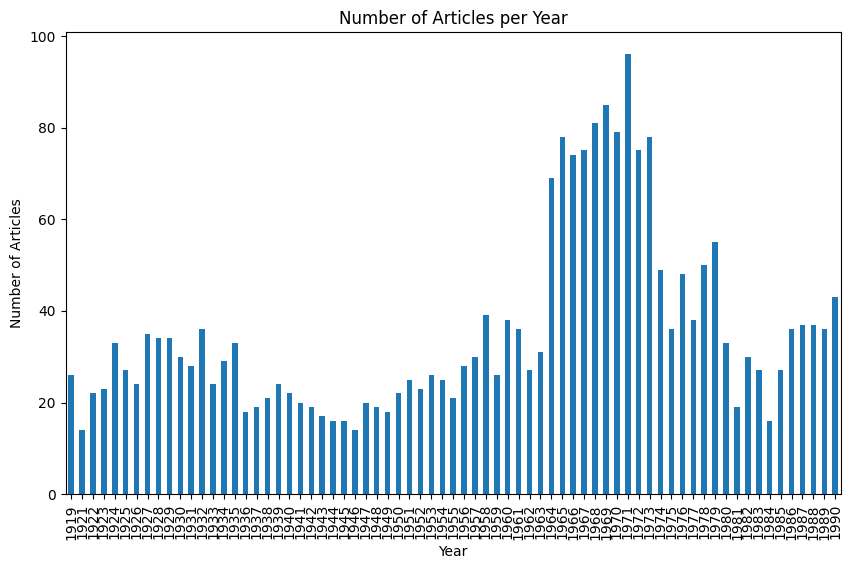

In [68]:
articles_per_year = df_clean.groupby('year').size()
# Plot the results
plt.figure(figsize=(10, 6))
articles_per_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Year')
plt.show()

In [69]:
# Function to remove numbers from text
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Apply the function to the 'text' column
df_clean['text'] = df_clean['text'].apply(remove_numbers)

In [70]:
df_clean.to_csv("df_cleaned.csv", index=False)